In [2]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [28]:
import os
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import skimage.transform
from tqdm import tqdm, tqdm_notebook
from keras.preprocessing.image import load_img, img_to_array, array_to_img

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical


import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
imageSize=224

train_dir = 'data/train/'
validation_dir = 'data/validation/'
test_dir = 'data/test/'

In [5]:
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['benign']:
                label = 0
            elif folderName in ['malignant']:
                label = 1
#             else:
#                 label = 4
            for image_filename in tqdm_notebook(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [6]:
X_train, y_train = get_data(train_dir)

In [8]:
X_validation, y_validation= get_data(validation_dir)

In [7]:
X_test, y_test= get_data(test_dir)

In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_validation.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (320, 224, 224, 3)
y_train shape: (320,)
X_validation shape: (67, 224, 224, 3)
y_validation shape: (67,)
X_test shape: (39, 224, 224, 3)
y_test shape: (39,)


In [10]:
y_trainHot = to_categorical(y_train, num_classes = 2)
y_valHot = to_categorical(y_validation, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_trainHot.shape)
print("X_validation shape:", X_validation.shape)
print("y_validation shape:", y_valHot.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_testHot.shape)

X_train shape: (320, 224, 224, 3)
y_train shape: (320, 2)
X_validation shape: (67, 224, 224, 3)
y_validation shape: (67, 2)
X_test shape: (39, 224, 224, 3)
y_test shape: (39, 2)


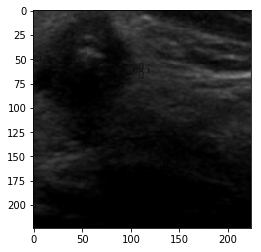

In [13]:
plt.imshow(X_train[0])
plt.show()

In [17]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
y_testHot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [19]:
input_shape = (imageSize, imageSize, 3)
output_classes = 2

from keras.applications import ResNet50
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model_dense_conv = ResNet50(weights='imagenet', include_top=False)  
    #Create your own input format
keras_input = Input(shape= input_shape, name = 'image_input')
    
    #Use the generated model 
output_dense_conv = model_dense_conv(keras_input)
    
    #Add the fully-connected layers 
x = Flatten(name='flatten')(output_dense_conv)
x = Dense(1024, activation= 'relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='fc1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation= 'relu', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='fc2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(output_classes, activation='softmax', kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001), name='predictions')(x)
    
    #Create your own model 
model = Model(inputs=keras_input, outputs=x)

In [20]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
# sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
# rmsp_opt = RMSprop(lr=1e-4, decay=0.9)

model.compile(optimizer = adam_opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(
  X_train, y_trainHot,
  batch_size = 8,
  epochs = 20,
  verbose=2,
  validation_data = (X_validation, y_valHot))

Train on 320 samples, validate on 67 samples
Epoch 1/20
 - 21s - loss: 1.7126 - acc: 0.4625 - val_loss: 1.4644 - val_acc: 0.4478
Epoch 2/20
 - 5s - loss: 1.5409 - acc: 0.5063 - val_loss: 1.3854 - val_acc: 0.5075
Epoch 3/20
 - 5s - loss: 1.3676 - acc: 0.5562 - val_loss: 1.3125 - val_acc: 0.5373
Epoch 4/20
 - 5s - loss: 1.4292 - acc: 0.5406 - val_loss: 1.3417 - val_acc: 0.4776
Epoch 5/20
 - 5s - loss: 1.2783 - acc: 0.5844 - val_loss: 1.2696 - val_acc: 0.4328
Epoch 6/20
 - 5s - loss: 1.2262 - acc: 0.6031 - val_loss: 1.3116 - val_acc: 0.4776
Epoch 7/20
 - 5s - loss: 1.2114 - acc: 0.5969 - val_loss: 1.3208 - val_acc: 0.5373
Epoch 8/20
 - 5s - loss: 1.1535 - acc: 0.5906 - val_loss: 1.3070 - val_acc: 0.5224
Epoch 9/20
 - 5s - loss: 1.1006 - acc: 0.6156 - val_loss: 1.3177 - val_acc: 0.4925
Epoch 10/20
 - 5s - loss: 1.2416 - acc: 0.6500 - val_loss: 1.2119 - val_acc: 0.4925
Epoch 11/20
 - 5s - loss: 1.2967 - acc: 0.5906 - val_loss: 1.2108 - val_acc: 0.5373
Epoch 12/20
 - 5s - loss: 1.0847 - acc:

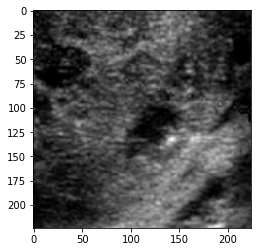

In [31]:
plt.imshow(array_to_img(X_test[0]))

In [25]:
predicts = model.predict(X_test, batch_size=128)
print(predicts)
print(predicts.shape)

[[4.88855362e-01 5.11144638e-01]
 [4.78354186e-01 5.21645844e-01]
 [2.17645347e-01 7.82354712e-01]
 [5.67994535e-01 4.32005465e-01]
 [4.48213965e-02 9.55178618e-01]
 [1.31689101e-01 8.68310869e-01]
 [9.15806115e-01 8.41938481e-02]
 [2.53361255e-01 7.46638715e-01]
 [2.85392731e-01 7.14607298e-01]
 [9.60654855e-01 3.93452086e-02]
 [9.35670018e-01 6.43300116e-02]
 [9.60654855e-01 3.93452086e-02]
 [9.87569392e-01 1.24306092e-02]
 [9.77819979e-01 2.21800301e-02]
 [9.79234815e-01 2.07652040e-02]
 [9.96608496e-01 3.39153316e-03]
 [9.64718223e-01 3.52817923e-02]
 [9.37366366e-01 6.26336560e-02]
 [3.14653188e-01 6.85346842e-01]
 [7.40587771e-01 2.59412259e-01]
 [8.84654224e-01 1.15345754e-01]
 [9.08945382e-01 9.10545439e-02]
 [7.59479821e-01 2.40520179e-01]
 [7.33025372e-02 9.26697433e-01]
 [4.08505112e-01 5.91494918e-01]
 [8.21378350e-01 1.78621650e-01]
 [1.47426669e-02 9.85257328e-01]
 [7.61961984e-03 9.92380381e-01]
 [3.21579337e-01 6.78420663e-01]
 [1.11624613e-01 8.88375401e-01]
 [1.187802